# Time Series Consumption Forecasting
We load the merged hourly dataset, split it into pre-war and war periods, and compare several regressors (Decision Tree, Random Forest, Gradient Boosting, Linear Regression) on each segment. The target variable is `consumption_total`.

In [3]:
from pathlib import Path
from typing import Dict, List
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [4]:
ROOT = Path().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
DATA_PATH = ROOT / "data" / "processed" / "merged" / "merged_all_years.csv"
WAR_START = pd.Timestamp(2022, 2, 24)
TARGET_COL = "consumption_total"
df = pd.read_csv(DATA_PATH)
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
df = df.dropna(subset=["datetime", TARGET_COL]).sort_values("datetime").reset_index(drop=True)
missing_ratio = df.isna().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.8].index.tolist()
if high_missing_cols:
    df = df.drop(columns=high_missing_cols)
    print(f"Dropped highly missing columns: {high_missing_cols}")
leakage_cols = [col for col in df.columns if col.startswith("consumption_") and col != TARGET_COL]
FEATURE_EXCLUDE = {"datetime", TARGET_COL}
FEATURE_EXCLUDE.update(leakage_cols)
feature_columns = [col for col in df.columns if col not in FEATURE_EXCLUDE]
if leakage_cols:
    print(f"Excluding potential leakage features: {leakage_cols}")
print(f"Feature count after filtering: {len(feature_columns)}")
pre_war_df = df[df["datetime"] < WAR_START].copy()
war_df = df[df["datetime"] >= WAR_START].copy()
print(f"Full dataset rows: {len(df):,}")
print(f"Pre-war rows (before {WAR_START.date()}): {len(pre_war_df):,}")
print(f"War-period rows (from {WAR_START.date()} onwards): {len(war_df):,}")

Excluding potential leakage features: ['consumption_gasnet', 'consumption_jmpnet', 'consumption_smpnet', 'consumption_vcpnet']
Feature count after filtering: 31
Full dataset rows: 113,153
Pre-war rows (before 2022-02-24): 80,152
War-period rows (from 2022-02-24 onwards): 33,001


In [5]:
def temporal_train_test_split(data: pd.DataFrame, target: str, test_size: float = 0.2):
    if data.empty:
        raise ValueError("Provided dataframe is empty.")
    split_idx = int(len(data) * (1 - test_size))
    split_idx = max(1, split_idx)
    train, test = data.iloc[:split_idx], data.iloc[split_idx:]
    if test.empty:
        raise ValueError("Test set is empty; adjust the test_size or provide more data.")
    feature_cols = [col for col in data.columns if col not in FEATURE_EXCLUDE]
    X_train, y_train = train[feature_cols], train[target]
    X_test, y_test = test[feature_cols], test[target]
    return X_train, X_test, y_train, y_test, feature_cols
models: Dict[str, object] = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=120, max_depth=14, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
}
def build_pipeline(model_name: str, estimator) -> Pipeline:
    steps = [("imputer", SimpleImputer(strategy="median"))]
    if model_name == "Linear Regression":
        steps.append(("scaler", StandardScaler()))
    steps.append(("model", estimator))
    return Pipeline(steps)
def evaluate_period(data: pd.DataFrame, period_label: str) -> List[Dict[str, float]]:
    X_train, X_test, y_train, y_test, feature_cols = temporal_train_test_split(data, TARGET_COL)
    results = []
    for model_name, estimator in models.items():
        pipeline = build_pipeline(model_name, estimator)
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        results.append({
            "period": period_label,
            "model": model_name,
            "train_rows": len(X_train),
            "test_rows": len(X_test),
            "MAE": mean_absolute_error(y_test, preds),
            "RMSE": mean_squared_error(y_test, preds) ** 0.5,
            "R2": r2_score(y_test, preds),
        })
    return results

In [6]:
pd.options.display.float_format = "{:,.2f}".format

# Create cumulative datasets to test the breaking point effect
# 80% dataset: data up to war start (to see pre-war patterns)
# 100% dataset: full timeline including war period (to see breaking point impact)
data_80_percent = df[df["datetime"] < WAR_START].copy()
data_100_percent = df.copy()

periods = [
    ("80% Dataset (Pre-war only, up to 2022-02-23)", data_80_percent),
    ("100% Dataset (Full timeline, including war impact)", data_100_percent),
]

results = []
for label, subset in periods:
    if len(subset) < 100:
        print(f"Skipping {label} due to insufficient rows ({len(subset)})")
        continue
    print(f"\nEvaluating: {label}")
    print(f"Date range: {subset['datetime'].min()} to {subset['datetime'].max()}")
    period_results = evaluate_period(subset, label)
    results.extend(period_results)

results_df = pd.DataFrame(results)
if not results_df.empty:
    metrics_order = ["period", "model", "train_rows", "test_rows", "MAE", "RMSE", "R2"]
    results_df = results_df[metrics_order].sort_values(["period", "RMSE"]).reset_index(drop=True)
results_df


Evaluating: 80% Dataset (Pre-war only, up to 2022-02-23)
Date range: 2013-01-01 00:00:00 to 2022-02-23 23:00:00

Evaluating: 100% Dataset (Full timeline, including war impact)
Date range: 2013-01-01 00:00:00 to 2025-11-30 00:00:00

Evaluating: 100% Dataset (Full timeline, including war impact)
Date range: 2013-01-01 00:00:00 to 2025-11-30 00:00:00


,period,model,train_rows,test_rows,MAE,RMSE,R2
0,"100% Dataset (Full timeline, including war imp...",Linear Regression,90522,22631,"398,771.11","485,895.42",-1.22
1,"100% Dataset (Full timeline, including war imp...",Random Forest,90522,22631,"174,214.32","1,946,507.08",-34.71
2,"100% Dataset (Full timeline, including war imp...",Gradient Boosting,90522,22631,"265,608.06","3,031,745.52",-85.62
3,"100% Dataset (Full timeline, including war imp...",Decision Tree,90522,22631,"236,199.39","11,516,228.82","-1,248.82"
4,"80% Dataset (Pre-war only, up to 2022-02-23)",Linear Regression,64121,16031,"1,442,518.49","20,245,820.50",-0.01
5,"80% Dataset (Pre-war only, up to 2022-02-23)",Random Forest,64121,16031,"698,966.93","20,924,734.33",-0.08
6,"80% Dataset (Pre-war only, up to 2022-02-23)",Gradient Boosting,64121,16031,"1,068,457.51","22,572,563.67",-0.25
7,"80% Dataset (Pre-war only, up to 2022-02-23)",Decision Tree,64121,16031,"687,608.87","23,622,416.41",-0.37


In [7]:
# Pivot table to compare model performance between 80% (pre-war) vs 100% (with war impact)
pivot = None
if not results_df.empty:
    pivot = results_df.pivot(index="model", columns="period", values=["MAE", "RMSE", "R2"])
    print("Performance Comparison: 80% (Pre-war) vs 100% (Including War Impact)")
    print("=" * 80)
    
pivot

Performance Comparison: 80% (Pre-war) vs 100% (Including War Impact)


MAE  \
period            100% Dataset (Full timeline, including war impact)   
model                                                                  
Decision Tree                                             236,199.39   
Gradient Boosting                                         265,608.06   
Linear Regression                                         398,771.11   
Random Forest                                             174,214.32   

                                                                \
period            80% Dataset (Pre-war only, up to 2022-02-23)   
model                                                            
Decision Tree                                       687,608.87   
Gradient Boosting                                 1,068,457.51   
Linear Regression                                 1,442,518.49   
Random Forest                                       698,966.93   

                                                                RMSE  \
period            100% Dataset (Full timeline, including war impact)   
model                                                                  
Decision Tree                                          11,516,228.82   
Gradient Boosting                                       3,031,745.52   
Linear Regression                                         485,895.42   
Random Forest                                           1,946,507.08   

                                                                \
period            80% Dataset (Pre-war only, up to 2022-02-23)   
model                                                            
Decision Tree                                    23,622,416.41   
Gradient Boosting                                22,572,563.67   
Linear Regression                                20,245,820.50   
Random Forest                                    20,924,734.33   

                                                                  R2  \
period            100% Dataset (Full timeline, including war impact)   
model                                                                  
Decision Tree                                              -1,248.82   
Gradient Boosting                                             -85.62   
Linear Regression                                              -1.22   
Random Forest                                                 -34.71   

                                                                
period            80% Dataset (Pre-war only, up to 2022-02-23)  
model                                                           
Decision Tree                                            -0.37  
Gradient Boosting                                        -0.25  
Linear Regression                                        -0.01  
Random Forest                                            -0.08

R2 data shape and content:
period             100% Dataset (Full timeline, including war impact)  \
model                                                                   
Decision Tree                                              -1,248.82    
Gradient Boosting                                             -85.62    
Linear Regression                                              -1.22    
Random Forest                                                 -34.71    

period             80% Dataset (Pre-war only, up to 2022-02-23)  
model                                                            
Decision Tree                                             -0.37  
Gradient Boosting                                         -0.25  
Linear Regression                                         -0.01  
Random Forest                                             -0.08  

R2 matrix:
period             100% Dataset (Full timeline, including war impact)  \
model                                                

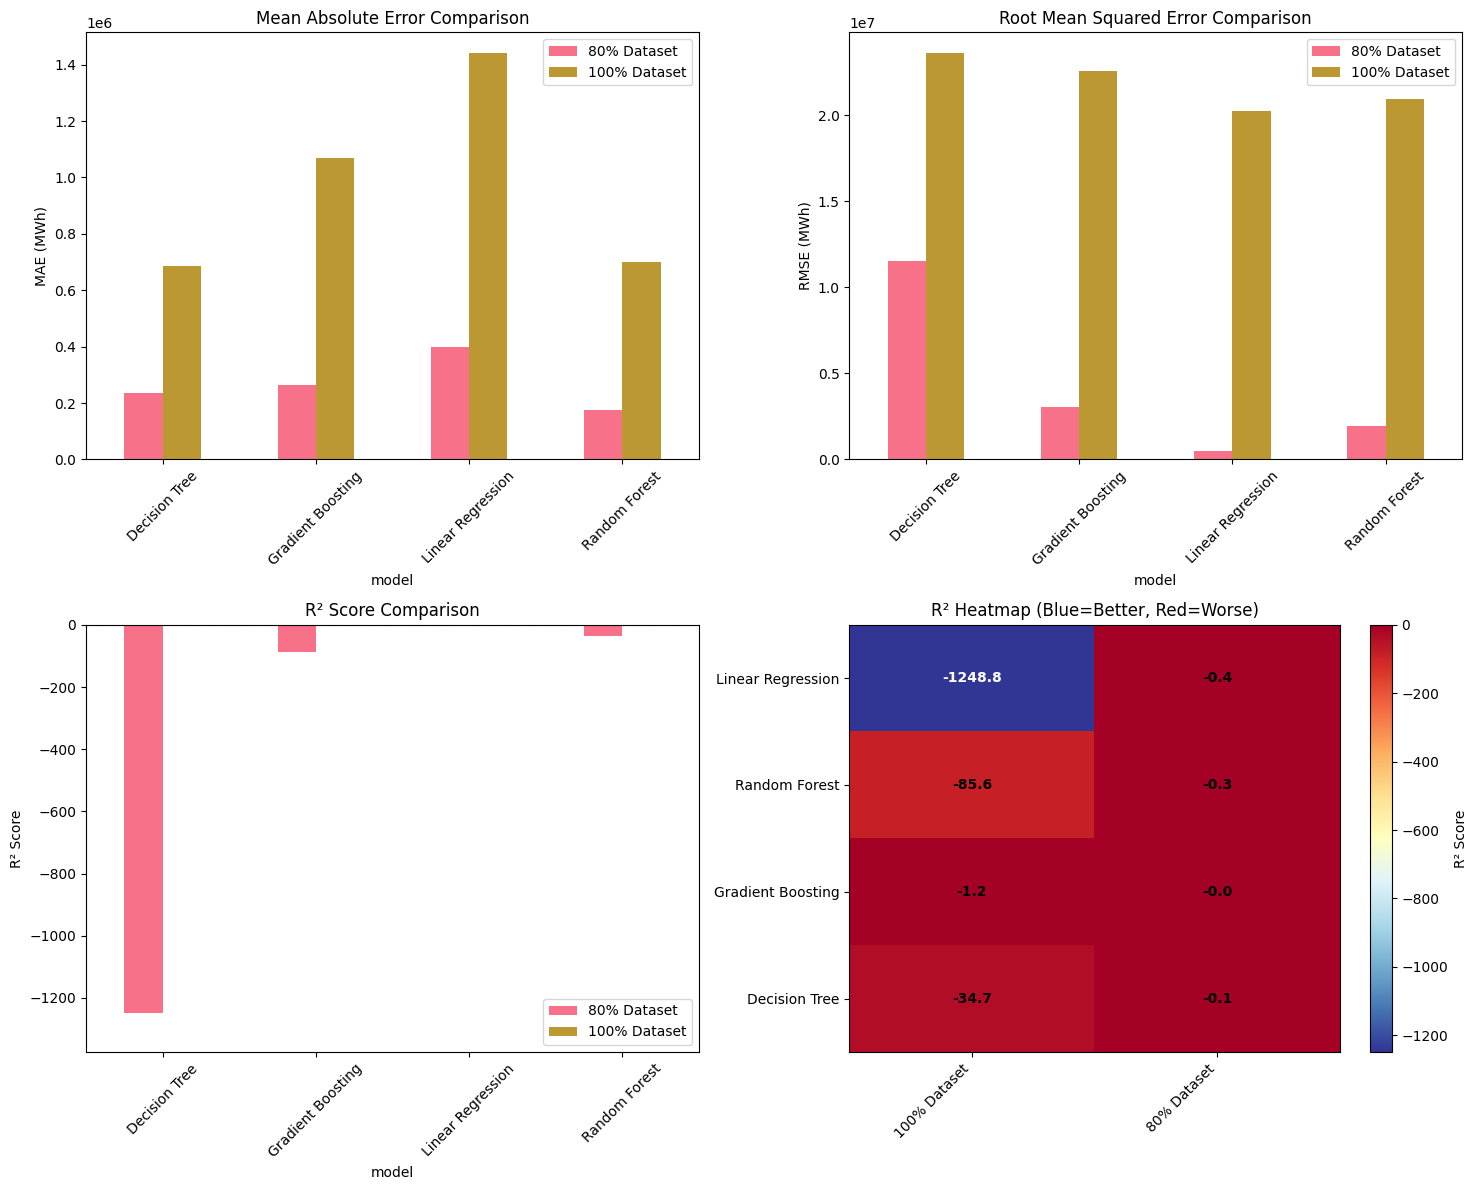

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. MAE Comparison
mae_data = pivot['MAE'].reset_index()
mae_data.plot(x='model', kind='bar', ax=axes[0, 0], 
              title='Mean Absolute Error Comparison')
axes[0, 0].set_ylabel('MAE (MWh)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(['80% Dataset', '100% Dataset'])

# 2. RMSE Comparison
rmse_data = pivot['RMSE'].reset_index()
rmse_data.plot(x='model', kind='bar', ax=axes[0, 1], 
               title='Root Mean Squared Error Comparison')
axes[0, 1].set_ylabel('RMSE (MWh)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(['80% Dataset', '100% Dataset'])

# 3. R² Comparison - Debug and fix visualization
print("R2 data shape and content:")
print(pivot['R2'])
r2_data = pivot['R2'].reset_index()
r2_data.plot(x='model', kind='bar', ax=axes[1, 0], 
             title='R² Score Comparison')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(['80% Dataset', '100% Dataset'])
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Baseline (mean)')
# Adjust y-axis to show very negative values properly
r2_min = r2_data.iloc[:, 1:].min().min()
axes[1, 0].set_ylim(r2_min * 1.1, 0.2)

# 4. Model Performance Overview (R² focus) - Fixed for extreme values
models_list = results_df['model'].unique()
periods_list = results_df['period'].unique()
r2_matrix = results_df.pivot(index='model', columns='period', values='R2')

print(f"\nR2 matrix:\n{r2_matrix}")

# Use better colormap for extreme negative values
im = axes[1, 1].imshow(r2_matrix.values, cmap='RdYlBu_r', aspect='auto', 
                       vmin=r2_matrix.values.min(), vmax=max(0, r2_matrix.values.max()))
axes[1, 1].set_xticks(range(len(periods_list)))
axes[1, 1].set_yticks(range(len(models_list)))
axes[1, 1].set_xticklabels([p.split('(')[0].strip() for p in periods_list], rotation=45, ha='right')
axes[1, 1].set_yticklabels(models_list)
axes[1, 1].set_title('R² Heatmap (Blue=Better, Red=Worse)')

# Add colorbar with better labeling
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('R² Score')

# Add text annotations with appropriate colors
for i in range(len(models_list)):
    for j in range(len(periods_list)):
        value = r2_matrix.iloc[i, j]
        color = "white" if abs(value) > 100 else "black"
        text = axes[1, 1].text(j, i, f'{value:.1f}',
                               ha="center", va="center", color=color, fontweight="bold")

plt.tight_layout()
plt.show()

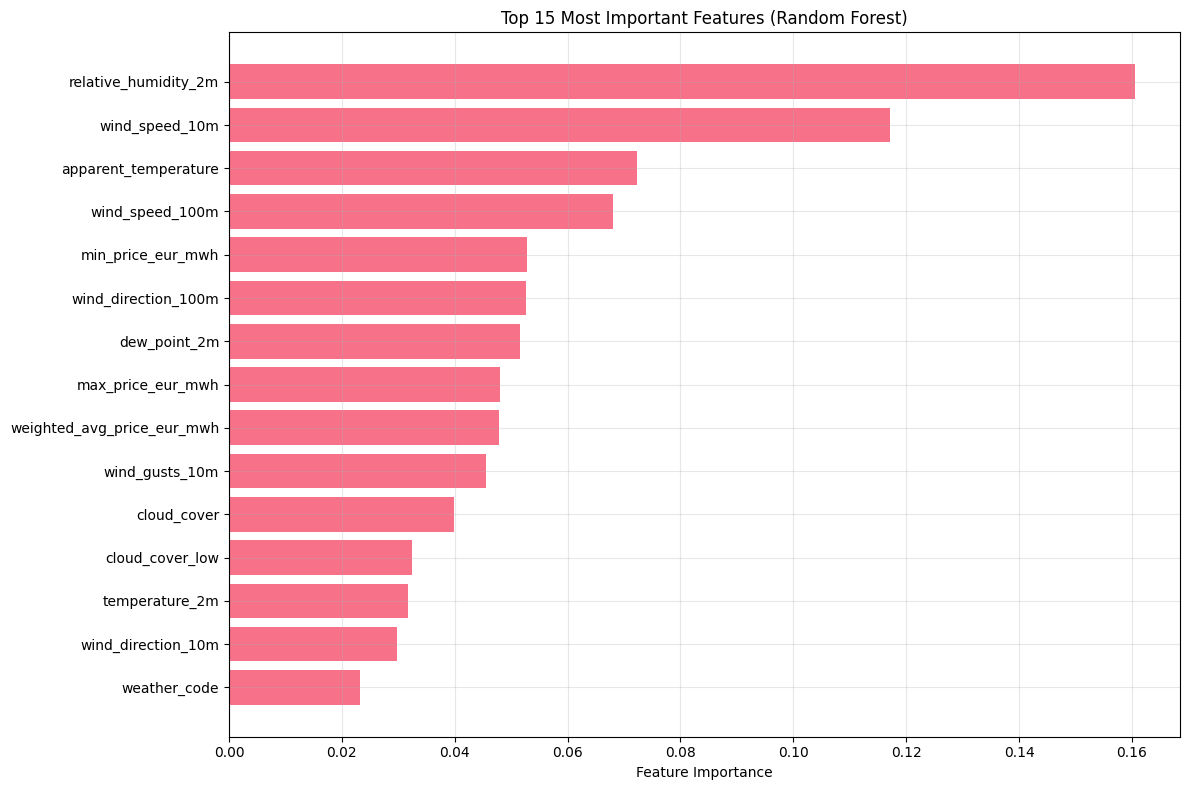

Top 10 Most Important Features:
                       feature  importance
20        relative_humidity_2m        0.16
12              wind_speed_10m        0.12
22        apparent_temperature        0.07
11             wind_speed_100m        0.07
29           min_price_eur_mwh        0.05
9          wind_direction_100m        0.05
21                dew_point_2m        0.05
30           max_price_eur_mwh        0.05
28  weighted_avg_price_eur_mwh        0.05
8               wind_gusts_10m        0.05


In [9]:
# Feature importance for Random Forest (best performing model)
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest on full dataset to get feature importance
rf_model = RandomForestRegressor(n_estimators=120, max_depth=14, random_state=42, n_jobs=-1)
X_full = df[feature_columns].fillna(df[feature_columns].median())
y_full = df[TARGET_COL]

rf_model.fit(X_full, y_full)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

## Hourly-Specific Decision Trees (24 Models)
Your thesis supervisor's excellent suggestion: create separate decision trees for each hour of the day to capture hourly consumption patterns better than a single model.

In [11]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, median_absolute_error,
    max_error, explained_variance_score
)
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

def comprehensive_metrics(y_true, y_pred, model_name="Model"):
    """Calculate comprehensive regression metrics"""
    # Handle potential issues
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Remove any infinite or NaN values
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    if len(y_true_clean) == 0:
        return {f"{model_name}_error": "No valid predictions"}
    
    metrics = {}
    
    try:
        # Basic metrics
        metrics[f'{model_name}_MAE'] = mean_absolute_error(y_true_clean, y_pred_clean)
        metrics[f'{model_name}_RMSE'] = mean_squared_error(y_true_clean, y_pred_clean) ** 0.5
        metrics[f'{model_name}_MSE'] = mean_squared_error(y_true_clean, y_pred_clean)
        metrics[f'{model_name}_R2'] = r2_score(y_true_clean, y_pred_clean)
        
        # Additional regression metrics
        metrics[f'{model_name}_MAPE'] = mean_absolute_percentage_error(y_true_clean, y_pred_clean) * 100
        metrics[f'{model_name}_MedAE'] = median_absolute_error(y_true_clean, y_pred_clean)
        metrics[f'{model_name}_MaxError'] = max_error(y_true_clean, y_pred_clean)
        metrics[f'{model_name}_ExplVar'] = explained_variance_score(y_true_clean, y_pred_clean)
        
        # Statistical correlations
        if len(np.unique(y_pred_clean)) > 1:
            pearson_r, pearson_p = pearsonr(y_true_clean, y_pred_clean)
            spearman_r, spearman_p = spearmanr(y_true_clean, y_pred_clean)
            metrics[f'{model_name}_PearsonR'] = pearson_r
            metrics[f'{model_name}_SpearmanR'] = spearman_r
        
        # Custom metrics
        mean_true = np.mean(y_true_clean)
        metrics[f'{model_name}_NMAE'] = metrics[f'{model_name}_MAE'] / mean_true  # Normalized MAE
        metrics[f'{model_name}_NRMSE'] = metrics[f'{model_name}_RMSE'] / mean_true  # Normalized RMSE
        
        # Residual analysis
        residuals = y_true_clean - y_pred_clean
        metrics[f'{model_name}_ResidualMean'] = np.mean(residuals)
        metrics[f'{model_name}_ResidualStd'] = np.std(residuals)
        
        # Percentage within tolerance bands
        tolerance_5 = np.mean(np.abs(residuals / y_true_clean) <= 0.05) * 100
        tolerance_10 = np.mean(np.abs(residuals / y_true_clean) <= 0.10) * 100
        tolerance_20 = np.mean(np.abs(residuals / y_true_clean) <= 0.20) * 100
        
        metrics[f'{model_name}_Within5pct'] = tolerance_5
        metrics[f'{model_name}_Within10pct'] = tolerance_10
        metrics[f'{model_name}_Within20pct'] = tolerance_20
        
    except Exception as e:
        metrics[f'{model_name}_error'] = str(e)
    
    return metrics

def train_hourly_decision_trees(data, target_col, feature_cols):
    """Train 24 separate decision trees for each hour of the day"""
    hourly_models = {}
    hourly_results = []
    
    print("Training hourly-specific decision trees...")
    for hour in range(24):
        print(f"Training model for hour {hour:02d}:00")
        
        # Filter data for this specific hour
        hour_data = data[data['hour'] == hour].copy()
        
        if len(hour_data) < 50:  # Skip if insufficient data
            print(f"  Skipping hour {hour} - insufficient data ({len(hour_data)} samples)")
            continue
            
        # Temporal split for this hour
        split_idx = int(len(hour_data) * 0.8)
        train_data = hour_data.iloc[:split_idx]
        test_data = hour_data.iloc[split_idx:]
        
        if len(test_data) < 5:
            print(f"  Skipping hour {hour} - insufficient test data")
            continue
            
        # Prepare features (exclude 'hour' since it's constant for this model)
        hour_features = [col for col in feature_cols if col != 'hour']
        
        X_train = train_data[hour_features].fillna(train_data[hour_features].median())
        y_train = train_data[target_col]
        X_test = test_data[hour_features].fillna(train_data[hour_features].median())
        y_test = test_data[target_col]
        
        # Train decision tree for this hour
        dt_model = DecisionTreeRegressor(max_depth=12, min_samples_split=10, random_state=42)
        dt_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = dt_model.predict(X_test)
        
        # Calculate comprehensive metrics
        metrics = comprehensive_metrics(y_test, y_pred, f"Hour{hour:02d}")
        metrics['hour'] = hour
        metrics['train_samples'] = len(train_data)
        metrics['test_samples'] = len(test_data)
        
        hourly_results.append(metrics)
        hourly_models[hour] = dt_model
        
        print(f"  Hour {hour:02d}: MAE={metrics[f'Hour{hour:02d}_MAE']:.0f}, RMSE={metrics[f'Hour{hour:02d}_RMSE']:.0f}, R²={metrics[f'Hour{hour:02d}_R2']:.3f}")
    
    return hourly_models, hourly_results

# Train hourly models on both datasets
print("="*60)
print("HOURLY DECISION TREES - 80% DATASET (Pre-war)")
print("="*60)
hourly_models_80, hourly_results_80 = train_hourly_decision_trees(
    data_80_percent, TARGET_COL, feature_columns
)

print("\n" + "="*60)
print("HOURLY DECISION TREES - 100% DATASET (Full timeline)")
print("="*60)
hourly_models_100, hourly_results_100 = train_hourly_decision_trees(
    data_100_percent, TARGET_COL, feature_columns
)

HOURLY DECISION TREES - 80% DATASET (Pre-war)
Training hourly-specific decision trees...
Training model for hour 00:00
  Hour 00: MAE=81476, RMSE=104234, R²=0.853
Training model for hour 01:00
  Hour 00: MAE=81476, RMSE=104234, R²=0.853
Training model for hour 01:00
  Hour 01: MAE=79724, RMSE=102343, R²=0.855
Training model for hour 02:00
  Hour 01: MAE=79724, RMSE=102343, R²=0.855
Training model for hour 02:00
  Hour 02: MAE=95115, RMSE=436563, R²=-1.546
Training model for hour 03:00
  Hour 02: MAE=95115, RMSE=436563, R²=-1.546
Training model for hour 03:00
  Hour 03: MAE=87964, RMSE=113910, R²=0.838
Training model for hour 04:00
  Hour 03: MAE=87964, RMSE=113910, R²=0.838
Training model for hour 04:00
  Hour 04: MAE=91075, RMSE=121049, R²=0.832
Training model for hour 05:00
  Hour 04: MAE=91075, RMSE=121049, R²=0.832
Training model for hour 05:00
  Hour 05: MAE=106606, RMSE=145099, R²=0.804
Training model for hour 06:00
  Hour 05: MAE=106606, RMSE=145099, R²=0.804
Training model for 

In [12]:
# Convert hourly results to DataFrames for analysis
hourly_df_80 = pd.DataFrame(hourly_results_80)
hourly_df_100 = pd.DataFrame(hourly_results_100)

if not hourly_df_80.empty and not hourly_df_100.empty:
    # Create comprehensive comparison
    print("\n" + "="*80)
    print("COMPREHENSIVE METRICS COMPARISON")
    print("="*80)
    
    # Key metrics for comparison
    key_metrics = ['MAE', 'RMSE', 'R2', 'MAPE', 'MedAE', 'ExplVar', 'PearsonR', 'Within10pct']
    
    comparison_data = []
    
    for hour in range(24):
        if hour in hourly_df_80['hour'].values and hour in hourly_df_100['hour'].values:
            row_80 = hourly_df_80[hourly_df_80['hour'] == hour].iloc[0]
            row_100 = hourly_df_100[hourly_df_100['hour'] == hour].iloc[0]
            
            comparison = {'hour': hour}
            for metric in key_metrics:
                col_80 = f'Hour{hour:02d}_{metric}'
                col_100 = f'Hour{hour:02d}_{metric}'
                
                if col_80 in row_80 and col_100 in row_100:
                    comparison[f'{metric}_80pct'] = row_80[col_80]
                    comparison[f'{metric}_100pct'] = row_100[col_100]
                    
                    # Calculate improvement/degradation
                    val_80, val_100 = row_80[col_80], row_100[col_100]
                    if metric in ['MAE', 'RMSE', 'MAPE', 'MedAE']:  # Lower is better
                        improvement = ((val_80 - val_100) / val_80) * 100 if val_80 != 0 else 0
                    else:  # Higher is better (R2, correlation, etc.)
                        improvement = ((val_100 - val_80) / abs(val_80)) * 100 if val_80 != 0 else 0
                    
                    comparison[f'{metric}_improvement'] = improvement
            
            comparison_data.append(comparison)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    if not comparison_df.empty:
        print("Hourly Model Performance Summary:")
        print("(Positive improvement = 100% dataset is better)")
        print("-" * 80)
        
        # Display summary statistics
        summary_cols = [col for col in comparison_df.columns if 'improvement' in col]
        for col in summary_cols:
            metric_name = col.replace('_improvement', '')
            mean_improvement = comparison_df[col].mean()
            print(f"{metric_name:12} improvement: {mean_improvement:+6.2f}% (avg across hours)")
        
        # Show the comparison table
        display_cols = ['hour'] + [col for col in comparison_df.columns if any(m in col for m in ['MAE', 'RMSE', 'R2'])]
        print(f"\nDetailed Hourly Comparison:")
        print(comparison_df[display_cols].round(3))
else:
    print("Insufficient data for hourly model comparison")


COMPREHENSIVE METRICS COMPARISON
Hourly Model Performance Summary:
(Positive improvement = 100% dataset is better)
--------------------------------------------------------------------------------
MAE          improvement: +10.40% (avg across hours)
RMSE         improvement: -176.15% (avg across hours)
R2           improvement: -13404505.73% (avg across hours)
MAPE         improvement: -42637181884512018432.00% (avg across hours)
MedAE        improvement: -20.01% (avg across hours)
ExplVar      improvement: -11231002.47% (avg across hours)
PearsonR     improvement: +7091.64% (avg across hours)
Within10pct  improvement: -31.65% (avg across hours)

Detailed Hourly Comparison:
    hour    MAE_80pct   MAE_100pct  MAE_improvement    RMSE_80pct  \
0      0    81,476.04    66,493.55            18.39    104,233.60   
1      1    79,724.08    78,905.41             1.03    102,343.37   
2      2    95,114.91    93,324.25             1.88    436,563.33   
3      3    87,964.31    93,548.35       

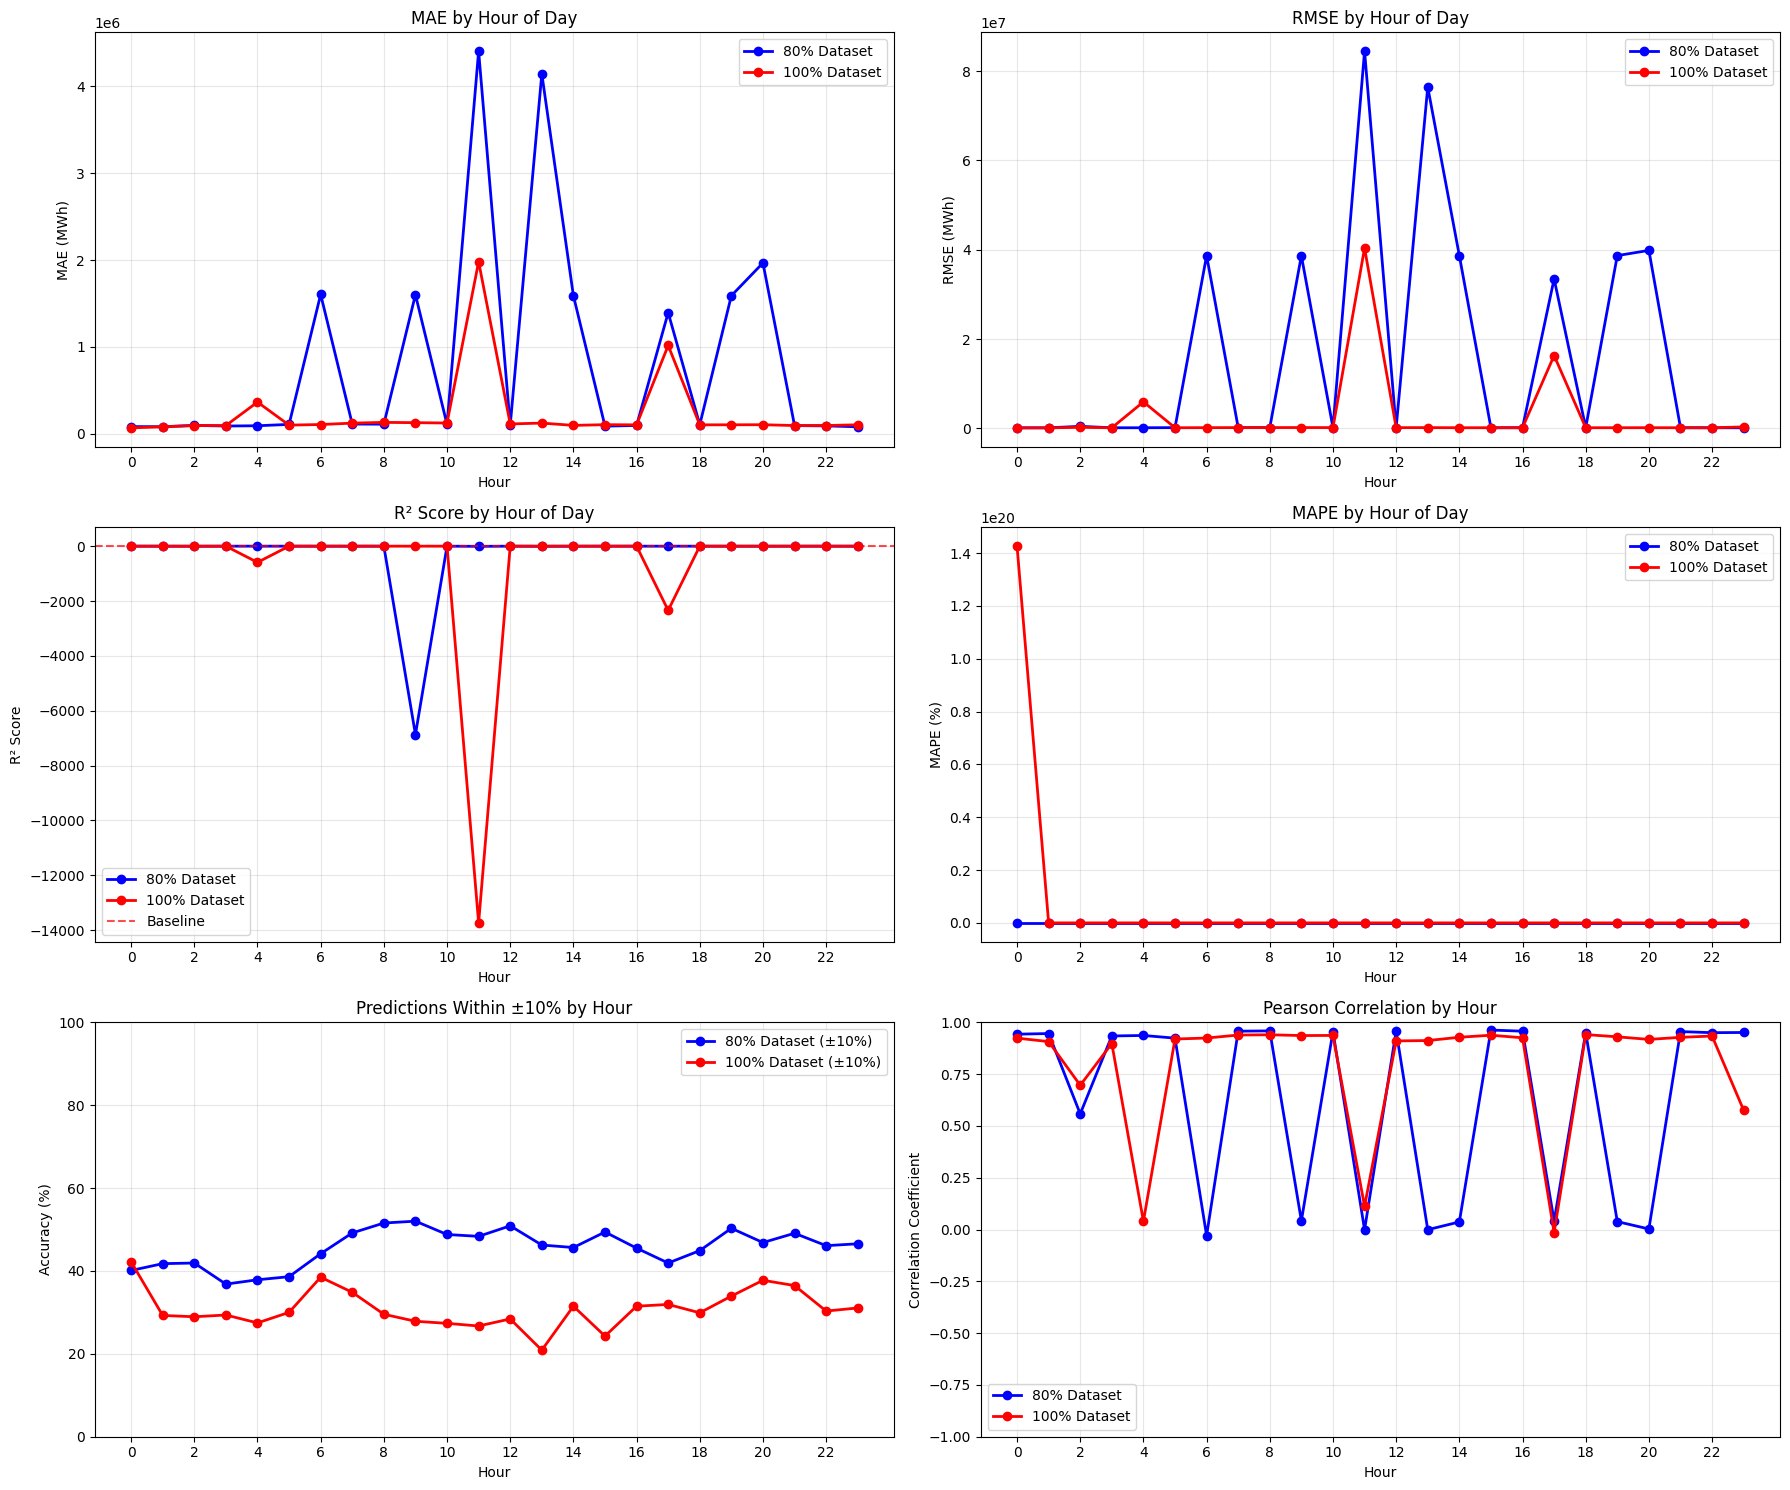


BEST AND WORST PERFORMING HOURS
Best performing hours (R² improvement):
    hour  R2_80pct  R2_100pct  R2_improvement
19    19     -0.00       0.85       96,124.41
14    14     -0.00       0.85       91,849.14
6      6     -0.00       0.82       35,403.91

Worst performing hours (R² improvement):
    hour  R2_80pct  R2_100pct  R2_improvement
17    17     -0.00  -2,339.75 -321,598,193.71
11    11     -5.20 -13,733.20     -263,908.54
4      4      0.83    -589.68      -70,960.37


In [13]:
# Comprehensive visualization of hourly models
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

if not hourly_df_80.empty and not hourly_df_100.empty:
    
    # 1. MAE by hour
    axes[0, 0].plot(hourly_df_80['hour'], [hourly_df_80.iloc[i][f'Hour{int(hourly_df_80.iloc[i]["hour"]):02d}_MAE'] 
                                           for i in range(len(hourly_df_80))], 
                    'bo-', label='80% Dataset', linewidth=2, markersize=6)
    axes[0, 0].plot(hourly_df_100['hour'], [hourly_df_100.iloc[i][f'Hour{int(hourly_df_100.iloc[i]["hour"]):02d}_MAE'] 
                                            for i in range(len(hourly_df_100))], 
                    'ro-', label='100% Dataset', linewidth=2, markersize=6)
    axes[0, 0].set_title('MAE by Hour of Day')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('MAE (MWh)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(range(0, 24, 2))
    
    # 2. RMSE by hour
    axes[0, 1].plot(hourly_df_80['hour'], [hourly_df_80.iloc[i][f'Hour{int(hourly_df_80.iloc[i]["hour"]):02d}_RMSE'] 
                                           for i in range(len(hourly_df_80))], 
                    'bo-', label='80% Dataset', linewidth=2, markersize=6)
    axes[0, 1].plot(hourly_df_100['hour'], [hourly_df_100.iloc[i][f'Hour{int(hourly_df_100.iloc[i]["hour"]):02d}_RMSE'] 
                                            for i in range(len(hourly_df_100))], 
                    'ro-', label='100% Dataset', linewidth=2, markersize=6)
    axes[0, 1].set_title('RMSE by Hour of Day')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('RMSE (MWh)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(range(0, 24, 2))
    
    # 3. R² by hour
    axes[1, 0].plot(hourly_df_80['hour'], [hourly_df_80.iloc[i][f'Hour{int(hourly_df_80.iloc[i]["hour"]):02d}_R2'] 
                                           for i in range(len(hourly_df_80))], 
                    'bo-', label='80% Dataset', linewidth=2, markersize=6)
    axes[1, 0].plot(hourly_df_100['hour'], [hourly_df_100.iloc[i][f'Hour{int(hourly_df_100.iloc[i]["hour"]):02d}_R2'] 
                                            for i in range(len(hourly_df_100))], 
                    'ro-', label='100% Dataset', linewidth=2, markersize=6)
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Baseline')
    axes[1, 0].set_title('R² Score by Hour of Day')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('R² Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. MAPE by hour
    axes[1, 1].plot(hourly_df_80['hour'], [hourly_df_80.iloc[i][f'Hour{int(hourly_df_80.iloc[i]["hour"]):02d}_MAPE'] 
                                           for i in range(len(hourly_df_80))], 
                    'bo-', label='80% Dataset', linewidth=2, markersize=6)
    axes[1, 1].plot(hourly_df_100['hour'], [hourly_df_100.iloc[i][f'Hour{int(hourly_df_100.iloc[i]["hour"]):02d}_MAPE'] 
                                            for i in range(len(hourly_df_100))], 
                    'ro-', label='100% Dataset', linewidth=2, markersize=6)
    axes[1, 1].set_title('MAPE by Hour of Day')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(0, 24, 2))
    
    # 5. Prediction accuracy within tolerance bands
    axes[2, 0].plot(hourly_df_80['hour'], [hourly_df_80.iloc[i][f'Hour{int(hourly_df_80.iloc[i]["hour"]):02d}_Within10pct'] 
                                           for i in range(len(hourly_df_80))], 
                    'bo-', label='80% Dataset (±10%)', linewidth=2, markersize=6)
    axes[2, 0].plot(hourly_df_100['hour'], [hourly_df_100.iloc[i][f'Hour{int(hourly_df_100.iloc[i]["hour"]):02d}_Within10pct'] 
                                            for i in range(len(hourly_df_100))], 
                    'ro-', label='100% Dataset (±10%)', linewidth=2, markersize=6)
    axes[2, 0].set_title('Predictions Within ±10% by Hour')
    axes[2, 0].set_xlabel('Hour')
    axes[2, 0].set_ylabel('Accuracy (%)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].set_xticks(range(0, 24, 2))
    axes[2, 0].set_ylim(0, 100)
    
    # 6. Correlation strength
    axes[2, 1].plot(hourly_df_80['hour'], [hourly_df_80.iloc[i][f'Hour{int(hourly_df_80.iloc[i]["hour"]):02d}_PearsonR'] 
                                           for i in range(len(hourly_df_80))], 
                    'bo-', label='80% Dataset', linewidth=2, markersize=6)
    axes[2, 1].plot(hourly_df_100['hour'], [hourly_df_100.iloc[i][f'Hour{int(hourly_df_100.iloc[i]["hour"]):02d}_PearsonR'] 
                                            for i in range(len(hourly_df_100))], 
                    'ro-', label='100% Dataset', linewidth=2, markersize=6)
    axes[2, 1].set_title('Pearson Correlation by Hour')
    axes[2, 1].set_xlabel('Hour')
    axes[2, 1].set_ylabel('Correlation Coefficient')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].set_xticks(range(0, 24, 2))
    axes[2, 1].set_ylim(-1, 1)

plt.tight_layout()
plt.show()

# Print best and worst performing hours
if not comparison_df.empty:
    print("\n" + "="*60)
    print("BEST AND WORST PERFORMING HOURS")
    print("="*60)
    
    # Sort by R2 improvement
    best_hours_r2 = comparison_df.nlargest(3, 'R2_improvement')[['hour', 'R2_80pct', 'R2_100pct', 'R2_improvement']]
    worst_hours_r2 = comparison_df.nsmallest(3, 'R2_improvement')[['hour', 'R2_80pct', 'R2_100pct', 'R2_improvement']]
    
    print("Best performing hours (R² improvement):")
    print(best_hours_r2.round(4))
    print("\nWorst performing hours (R² improvement):")
    print(worst_hours_r2.round(4))

## Enhanced Model Evaluation with Comprehensive Metrics

Now let's re-evaluate our original models (Decision Tree, Random Forest, Gradient Boosting, Linear Regression) using the comprehensive metrics framework to get much deeper insights than just MAE, RMSE, and R².

In [14]:
def evaluate_model_comprehensive(model_name, estimator, X_train, X_test, y_train, y_test, period_label):
    """Evaluate a model with comprehensive metrics"""
    
    # Build and train pipeline
    pipeline = build_pipeline(model_name, estimator)
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate comprehensive metrics
    metrics = comprehensive_metrics(y_test, y_pred, model_name)
    
    # Add metadata
    metrics['model'] = model_name
    metrics['period'] = period_label
    metrics['train_samples'] = len(X_train)
    metrics['test_samples'] = len(X_test)
    
    return metrics, pipeline

# Re-evaluate all models with comprehensive metrics
print("="*80)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*80)

comprehensive_results = []

for period_label, dataset in [("80% Dataset (Pre-war)", data_80_percent), 
                              ("100% Dataset (Full timeline)", data_100_percent)]:
    
    print(f"\nEvaluating: {period_label}")
    print("-" * 50)
    
    # Prepare data
    X_train, X_test, y_train, y_test, feature_cols = temporal_train_test_split(dataset, TARGET_COL)
    
    for model_name, estimator in models.items():
        print(f"  Training {model_name}...")
        
        try:
            metrics, trained_model = evaluate_model_comprehensive(
                model_name, estimator, X_train, X_test, y_train, y_test, period_label
            )
            comprehensive_results.append(metrics)
            
            # Print key metrics
            mae = metrics[f'{model_name}_MAE']
            rmse = metrics[f'{model_name}_RMSE']
            r2 = metrics[f'{model_name}_R2']
            mape = metrics[f'{model_name}_MAPE']
            within_10pct = metrics[f'{model_name}_Within10pct']
            
            print(f"    MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f} | MAPE: {mape:.1f}% | Within±10%: {within_10pct:.1f}%")
            
        except Exception as e:
            print(f"    Error training {model_name}: {str(e)}")

# Convert to DataFrame for analysis
comprehensive_df = pd.DataFrame(comprehensive_results)

print(f"\nGenerated comprehensive evaluation with {len(comprehensive_df)} model runs")
print("Available metrics:", [col for col in comprehensive_df.columns if any(m in col for m in ['MAE', 'RMSE', 'R2', 'MAPE', 'Within'])])

COMPREHENSIVE MODEL EVALUATION

Evaluating: 80% Dataset (Pre-war)
--------------------------------------------------
  Training Decision Tree...
    MAE: 687,609 | RMSE: 23,622,416 | R²: -0.372 | MAPE: 30.2% | Within±10%: 43.7%
  Training Random Forest...
    MAE: 687,609 | RMSE: 23,622,416 | R²: -0.372 | MAPE: 30.2% | Within±10%: 43.7%
  Training Random Forest...
    MAE: 698,967 | RMSE: 20,924,734 | R²: -0.077 | MAPE: 58.3% | Within±10%: 51.1%
  Training Gradient Boosting...
    MAE: 698,967 | RMSE: 20,924,734 | R²: -0.077 | MAPE: 58.3% | Within±10%: 51.1%
  Training Gradient Boosting...
    MAE: 1,068,458 | RMSE: 22,572,564 | R²: -0.253 | MAPE: 134.5% | Within±10%: 26.4%
  Training Linear Regression...
    MAE: 1,068,458 | RMSE: 22,572,564 | R²: -0.253 | MAPE: 134.5% | Within±10%: 26.4%
  Training Linear Regression...
    MAE: 1,442,518 | RMSE: 20,245,821 | R²: -0.008 | MAPE: 141.1% | Within±10%: 10.2%

Evaluating: 100% Dataset (Full timeline)
---------------------------------------

In [15]:
# Create comprehensive comparison tables
if not comprehensive_df.empty:
    
    # Organize metrics by category
    basic_metrics = ['MAE', 'RMSE', 'MSE', 'R2']
    percentage_metrics = ['MAPE', 'Within5pct', 'Within10pct', 'Within20pct'] 
    advanced_metrics = ['MedAE', 'MaxError', 'ExplVar', 'PearsonR', 'SpearmanR']
    normalized_metrics = ['NMAE', 'NRMSE']
    
    print("\n" + "="*100)
    print("COMPREHENSIVE METRICS COMPARISON TABLE")
    print("="*100)
    
    # Create comparison for each metric category
    for category_name, metric_list in [
        ("Basic Regression Metrics", basic_metrics),
        ("Percentage & Tolerance Metrics", percentage_metrics),
        ("Advanced Statistical Metrics", advanced_metrics),
        ("Normalized Metrics", normalized_metrics)
    ]:
        
        print(f"\n{category_name}:")
        print("-" * len(category_name))
        
        comparison_table = []
        
        for _, row in comprehensive_df.iterrows():
            model_name = row['model']
            period = row['period']
            
            row_data = {'Model': model_name, 'Period': period.split('(')[0].strip()}
            
            for metric in metric_list:
                col_name = f"{model_name}_{metric}"
                if col_name in row:
                    row_data[metric] = row[col_name]
            
            comparison_table.append(row_data)
        
        if comparison_table:
            comparison_df_cat = pd.DataFrame(comparison_table)
            
            # Pivot to show side-by-side comparison
            if len(comparison_df_cat) > 0:
                pivot_table = comparison_df_cat.pivot(index='Model', columns='Period', values=metric_list)
                
                # Format and display
                print(pivot_table.round(3))
    
    # Create overall ranking
    print(f"\n{'='*60}")
    print("MODEL RANKING BY KEY METRICS")
    print("="*60)
    
    ranking_data = []
    
    for _, row in comprehensive_df.iterrows():
        model_name = row['model']
        period = row['period']
        
        # Extract key metrics for ranking
        mae = row.get(f"{model_name}_MAE", float('inf'))
        rmse = row.get(f"{model_name}_RMSE", float('inf'))
        r2 = row.get(f"{model_name}_R2", -float('inf'))
        mape = row.get(f"{model_name}_MAPE", float('inf'))
        within_10pct = row.get(f"{model_name}_Within10pct", 0)
        
        # Calculate composite score (lower is better for errors, higher for accuracy)
        # Normalize to 0-100 scale where higher is better
        composite_score = (
            max(0, 100 - mae/10000) * 0.25 +      # MAE component
            max(0, 100 - rmse/100000) * 0.25 +    # RMSE component  
            max(0, min(100, (r2 + 1) * 50)) * 0.25 +  # R2 component (handle negative values)
            max(0, 100 - mape/2) * 0.15 +         # MAPE component
            within_10pct * 0.10                   # Tolerance component
        )
        
        ranking_data.append({
            'Model': model_name,
            'Period': period.split('(')[0].strip(),
            'MAE': mae,
            'RMSE': rmse, 
            'R²': r2,
            'MAPE%': mape,
            'Within±10%': within_10pct,
            'Composite_Score': composite_score
        })
    
    ranking_df = pd.DataFrame(ranking_data)
    
    # Sort by composite score
    ranking_df_sorted = ranking_df.sort_values(['Period', 'Composite_Score'], ascending=[True, False])
    
    print("Ranking (higher Composite Score = better overall performance):")
    print(ranking_df_sorted.round(2))
    
    # Best model per period
    print(f"\n{'='*40}")
    print("BEST MODEL PER PERIOD")
    print("="*40)
    
    for period in ranking_df['Period'].unique():
        period_data = ranking_df[ranking_df['Period'] == period]
        best_model = period_data.loc[period_data['Composite_Score'].idxmax()]
        
        print(f"{period}:")
        print(f"  Best Model: {best_model['Model']}")
        print(f"  Composite Score: {best_model['Composite_Score']:.2f}")
        print(f"  MAE: {best_model['MAE']:.0f}, RMSE: {best_model['RMSE']:.0f}, R²: {best_model['R²']:.3f}")

else:
    print("No comprehensive results available for analysis")


COMPREHENSIVE METRICS COMPARISON TABLE

Basic Regression Metrics:
------------------------
                           MAE                       RMSE                \
Period            100% Dataset  80% Dataset  100% Dataset   80% Dataset   
Model                                                                     
Decision Tree       236,199.39   687,608.87 11,516,228.82 23,622,416.41   
Gradient Boosting   265,608.06 1,068,457.51  3,031,745.52 22,572,563.67   
Linear Regression   398,771.11 1,442,518.49    485,895.42 20,245,820.50   
Random Forest       174,214.32   698,966.93  1,946,507.08 20,924,734.33   

                                     MSE                                  R2  \
Period                      100% Dataset            80% Dataset 100% Dataset   
Model                                                                          
Decision Tree     132,623,526,211,069.73 558,018,556,955,542.06    -1,248.82   
Gradient Boosting   9,191,480,870,156.32 509,520,630,775,009.2